In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
import math
import pickle

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
class Obj:
    pass

In [5]:
params = Obj()
params.input_dim = 784
params.n_l1 = 1000
params.n_l2 = 1000
params.n_labels = 10
params.z_dim = 15
params.batch_size = 100
params.n_epochs = 1000
params.learning_rate = 0.0002
params.beta1 = 0.5

In [6]:
results_path = './Results/Autoencoder'

In [7]:
def dense(x, n1, n2, name, stddev = .1):
    """
    Used to create a dense layer.
    :param x: input tensor to the dense layer
    :param n1: no. of input neurons
    :param n2: no. of output neurons
    :param name: name of the entire dense layer.i.e, variable scope name.
    :return: tensor with shape [batch_size, n2]
    """
    with tf.variable_scope(name, reuse=None):
        #xav_stddev = np.sqrt(2 / (n1 + n2))
        xav_stddev = stddev * np.sqrt( 1. / n1)
        #xav_stddev_b = np.sqrt(2 / n2)
        xav_stddev_b = stddev
        weights = tf.get_variable("weights", shape=[n1, n2],
                                  initializer=tf.random_normal_initializer(mean=0., stddev=xav_stddev))
        #bias = tf.get_variable("bias", shape=[n2], initializer=tf.constant_initializer(0.0))
        bias = tf.get_variable("bias", shape=[n2], initializer=tf.random_normal_initializer(mean=0., stddev=xav_stddev_b))
        matmul = tf.add(tf.matmul(x, weights), bias, name='matmul')
    return matmul

In [8]:
def encoder(x, params, reuse=False):
    """
    Encode part of the autoencoder
    :param x: input to the autoencoder
    :param reuse: True -> Reuse the encoder variables, False -> Create or search of variables before creating
    :return: tensor which is the hidden latent variable of the autoencoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Encoder'):
        e_dense_1 = tf.nn.relu(dense(x, params.input_dim, params.n_l1, 'e_dense_1'))
        e_dense_2 = tf.nn.relu(dense(e_dense_1, params.n_l1, params.n_l2, 'e_dense_2'))
        e_latent_variable = dense(e_dense_2, params.n_l2, params.z_dim, 'e_latent_variable')
        e_label = dense(e_dense_2, params.n_l2, params.n_labels, 'e_label')
    return e_label, e_latent_variable

In [9]:
def decoder(x, params, reuse=False):
    """
    Decoder part of the autoencoder
    :param x: input to the decoder
    :param reuse: True -> Reuse the decoder variables, False -> Create or search of variables before creating
    :return: tensor which should ideally be the input given to the encoder.
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Decoder'):
        d_dense_1 = tf.nn.relu(dense(x, params.n_labels + params.z_dim, params.n_l2, 'd_dense_1'))
        d_dense_2 = tf.nn.relu(dense(d_dense_1, params.n_l2, params.n_l1, 'd_dense_2'))
        #output = tf.nn.sigmoid(dense(d_dense_2, params.n_l1, params.input_dim, 'd_output'))
        d_output = dense(d_dense_2, params.n_l1, params.input_dim, 'd_output')
        return d_output

In [10]:
def discriminator_gauss(x, params, reuse=False):
    """
    Discriminator that is used to match the posterior distribution with a given prior distribution.
    :param x: tensor of shape [batch_size, z_dim]
    :param reuse: True -> Reuse the discriminator variables,
                  False -> Create or search of variables before creating
    :return: tensor of shape [batch_size, 1]
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Discriminator_Gauss'):
        dc_g_dense_1 = tf.nn.relu(dense(x, params.z_dim, params.n_l1, name='dc_g_dense_1'))
        dc_g_dense_2 = tf.nn.relu(dense(dc_g_dense_1, params.n_l1, params.n_l2, name='dc_g_dense_2'))
        dc_g_output = dense(dc_g_dense_2, params.n_l2, 1, name='dc_g_output')
    return dc_g_output

In [11]:
def discriminator_categorical(x, params, reuse=False):
    """
    Discriminator that is used to match the posterior distribution with a given prior distribution.
    :param x: tensor of shape [batch_size, z_dim]
    :param reuse: True -> Reuse the discriminator variables,
                  False -> Create or search of variables before creating
    :return: tensor of shape [batch_size, 1]
    """
    if reuse:
        tf.get_variable_scope().reuse_variables()
    with tf.name_scope('Discriminator_Categorical'):
        dc_c_dense_1 = tf.nn.relu(dense(x, params.n_labels, params.n_l1, name='dc_c_dense_1'))
        dc_c_dense_2 = tf.nn.relu(dense(dc_c_dense_1, params.n_l1, params.n_l2, name='dc_c_dense_2'))
        dc_c_output = dense(dc_c_dense_2, params.n_l2, 1, name='dc_c_output')
    return dc_c_output

In [12]:
x_input = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.input_dim], name='Input')
x_input_l = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.input_dim], name='Labeled_Input')
x_target = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.input_dim], name='Target')
y_label = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.n_labels], name='Labels')
real_distribution = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.z_dim], name='Real_distribution')
categorical_distribution = tf.placeholder(dtype=tf.float32, shape=[params.batch_size, params.n_labels], name='Categorical_distribution')
decoder_input = tf.placeholder(dtype=tf.float32, shape=[1, params.n_labels + params.z_dim], name='Decoder_input')

In [13]:
## phase 1

In [14]:
with tf.variable_scope(tf.get_variable_scope()):
    e_label_logit, e_latent_variable  = encoder(x_input, params)
    #e_softmax_label = tf.nn.softmax(logits=e_label_logit, name='e_softmax_label')
    e_softmax_label = tf.nn.sigmoid(e_label_logit, name='e_softmax_label')
    d_output = decoder(tf.concat([e_softmax_label, e_latent_variable], 1), params) 

In [15]:
## phase 2

In [16]:
with tf.variable_scope(tf.get_variable_scope()):
    d_g_real = discriminator_gauss(real_distribution, params)
    d_g_fake = discriminator_gauss(e_latent_variable, params, reuse=True)

In [17]:
with tf.variable_scope(tf.get_variable_scope()):
    d_c_real = discriminator_categorical(categorical_distribution, params)
    d_c_fake = discriminator_categorical(e_softmax_label, params, reuse=True)

In [18]:
#" phase 3 (classifier)

In [19]:
with tf.variable_scope(tf.get_variable_scope()):
    e_label_logit_l, _ = encoder(x_input_l, params, reuse=True)
    #e_softmax_label_l = tf.nn.softmax(logits=e_label_logit_l, name='e_softmax_label_l')
    e_softmax_label_l = tf.nn.sigmoid(e_label_logit_l, name='e_softmax_label_l')

In [20]:
with tf.variable_scope(tf.get_variable_scope()):
    decoder_image = decoder(decoder_input, params, reuse=True)

In [21]:
# Phase 1 autoencoder Loss

autoencoder_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_output, labels=x_target), reduction_indices=1)

# Phase 2 Discriminator Loss

# Gaussian Discriminator Loss
dc_g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_g_real), logits=d_g_real))
dc_g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_g_fake), logits=d_g_fake))
dc_g_loss = dc_g_loss_fake + dc_g_loss_real

# Categorical Discrimminator Loss
dc_c_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_c_real), logits=d_c_real))
dc_c_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_c_fake), logits=d_c_fake))
dc_c_loss = dc_c_loss_fake + dc_c_loss_real

# Generator loss
generator_g_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_g_real), logits=d_g_real))
generator_g_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_g_fake), logits=d_g_fake))
generator_g_loss = generator_g_loss_fake + generator_g_loss_real

generator_c_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(d_c_real), logits=d_c_real))
generator_c_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(d_c_fake), logits=d_c_fake))
generator_c_loss = generator_c_loss_fake + generator_c_loss_real

generator_loss = generator_c_loss + generator_g_loss

# Phase 3 : classifier loss

#supervised_encoder_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_label, logits=e_label_logit_l))
supervised_encoder_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label, logits=e_label_logit_l), reduction_indices=1)

In [22]:
all_variables = tf.trainable_variables()
dc_g_var = [var for var in all_variables if 'dc_g_' in var.name]
dc_c_var = [var for var in all_variables if 'dc_c_' in var.name]
en_var = [var for var in all_variables if 'e_' in var.name]

In [23]:
# Optimizer

# Phase 1
decoder_optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                           beta1=params.beta1).minimize(autoencoder_loss)

# Phase 2
discriminator_optimizer_real_g = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                        beta1=params.beta1).minimize(dc_g_loss_real,\
                                                                                     var_list=dc_g_var)
discriminator_optimizer_fake_g = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                        beta1=params.beta1).minimize(dc_g_loss_fake, \
                                                                                     var_list=dc_g_var)
generator_optimizer_real_g = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                    beta1=params.beta1).minimize(generator_g_loss_real, \
                                                                                 var_list=en_var)
generator_optimizer_fake_g = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                    beta1=params.beta1).minimize(generator_g_loss_fake, \
                                                                                 var_list=en_var)

discriminator_optimizer_real_c = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                        beta1=params.beta1).minimize(dc_c_loss_real, \
                                                                                     var_list=dc_c_var)
discriminator_optimizer_fake_c = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                        beta1=params.beta1).minimize(dc_c_loss_fake, \
                                                                                     var_list=dc_c_var)
generator_optimizer_real_c = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                    beta1=params.beta1).minimize(generator_c_loss_real, \
                                                                                 var_list=en_var)
generator_optimizer_fake_c = tf.train.AdamOptimizer(learning_rate=params.learning_rate,\
                                                    beta1=params.beta1).minimize(generator_c_loss_fake, \
                                                                                 var_list=en_var)
# Phase 3
supervised_encoder_optimizer = tf.train.AdamOptimizer(learning_rate=params.learning_rate, \
                                                      beta1=params.beta1).minimize(supervised_encoder_loss, \
                                                                            var_list=en_var)

In [24]:
# Evaluation
#gen_accuracy = tf.sqrt(tf.reduce_mean(tf.square(x_target - tf.nn.sigmoid(decoder_output))))
correct_prediction = tf.equal(tf.argmax(e_label_logit, 1), tf.argmax(y_label, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
gen_accuracy = tf.sqrt(tf.reduce_mean(tf.square(x_target - tf.nn.sigmoid(d_output))))

In [25]:
sess = tf.InteractiveSession()

In [26]:
turn = 1
if turn ==1:
    sess.run(tf.global_variables_initializer())

In [27]:
saver = tf.train.Saver()

In [28]:
#saver.restore(sess, "./AAE_Model4full_fullBase_alpha_1em4_beta1_9em1.ckpt")

In [29]:
def next_batch(params):
    if FLAG_SEMI:
        indices = np.arange(TEST_SIZE)
        np.random.shuffle(indices)
        batch_x, batch_y = subset_x[indices[:params.batch_size]], subset_y[indices[:params.batch_size]]
    else:
        batch_x, batch_y = mnist.train.next_batch(params.batch_size)
    return batch_x, batch_y

In [30]:
TEST_SIZE = 1000
FLAG_SEMI = False
FLAG_DECODE = True
FLAG_CLASSIF = True
FLAG_GAN = True

#params.learning_rate = 0.0001
#params.beta1 = 0.5

mem = Obj()
mem.num_epoch = []
mem.classif_eval = []
mem.decoder_eval = []
mem.dc_g_eval = []
mem.gen_g_eval =  []
mem.dc_c_eval = []
mem.gen_c_eval =  []

if FLAG_SEMI :
    subset_x, subset_y =  mnist.train.next_batch(TEST_SIZE)
    

In [162]:
params.n_epochs = 10000

for num_epoch in range (params.n_epochs):
    
    if num_epoch % 10 == 0:
        mem.num_epoch += [num_epoch]
        
        
        if FLAG_CLASSIF:
            x_test, y_test = mnist.test.next_batch(params.batch_size)
            classif_eval = accuracy.eval(feed_dict={x_input: x_test, y_label: y_test})
            mem.classif_eval += [classif_eval]
        else:
            classif_eval = 0
        
        x_test, y_test = next_batch(params)
        if FLAG_DECODE:
            decoder_eval = gen_accuracy.eval(feed_dict={x_input: x_test, y_label: y_test, x_target: x_test})
            mem.decoder_eval += [decoder_eval]
        else:
            decoder_eval = 0   
        
        if FLAG_GAN :
            z_real_dist = np.random.randn(params.batch_size, params.z_dim) 
            dc_g_eval = dc_g_loss.eval(feed_dict={x_input: x_test, \
                                                  real_distribution: z_real_dist})
            gen_g_eval = generator_g_loss.eval(feed_dict={x_input: x_test, \
                                                          real_distribution: z_real_dist})
            mem.dc_g_eval += [dc_g_eval]
            mem.gen_g_eval += [gen_g_eval]
            
            c_real_dist = np.random.randint(low=0, high=params.n_labels, size=params.batch_size)
            c_real_dist = np.eye(params.n_labels)[c_real_dist]
            dc_c_eval = dc_c_loss.eval(feed_dict={x_input: x_test, \
                                                  categorical_distribution: c_real_dist})
            gen_c_eval = generator_c_loss.eval(feed_dict={x_input: x_test, \
                                                      categorical_distribution: c_real_dist})
            mem.dc_c_eval += [dc_c_eval]
            mem.gen_c_eval += [gen_c_eval]        
        else:
            dc_g_eval = 0
            gen_g_eval = 0
            dc_c_eval = 0
            gen_c_eval = 0
            
        sys.stdout.write('\rstep %d\t dec : %.5f\t classif : %.5f\tdiscr_g : %.5f\t gen_g : %.5f, discr_c : %.5f\t gen_c : %.5f' \
                         % (num_epoch, \
                            decoder_eval, \
                            classif_eval,\
                            dc_g_eval, \
                            gen_g_eval, \
                            dc_c_eval, \
                            gen_c_eval))
    for _ in range(2):
        if FLAG_DECODE:
            batch_x, batch_y = next_batch(params) #mnist.train.next_batch(params.batch_size) #
            decoder_optimizer.run(feed_dict={x_input: batch_x, x_target: batch_x})

        if FLAG_CLASSIF: #and num_epoch % 10 == 0: # pour eviter le surapprentissage sur petites bases
            batch_x, batch_y = next_batch(params)
            supervised_encoder_optimizer.run(feed_dict={x_input_l: batch_x, y_label: batch_y})
    
    if FLAG_GAN :
        z_real_dist = np.random.randn(params.batch_size, params.z_dim) #* 5.
        discriminator_optimizer_real_g.run(feed_dict={real_distribution: z_real_dist})
        z_real_dist = np.random.randn(params.batch_size, params.z_dim) #* 5.
        generator_optimizer_real_g.run(feed_dict={real_distribution: z_real_dist})
        
        c_real_dist = np.random.randint(low=0, high=params.n_labels, size=params.batch_size)
        c_real_dist = np.eye(params.n_labels)[c_real_dist]
        discriminator_optimizer_real_c.run(feed_dict={categorical_distribution: c_real_dist})
        c_real_dist = np.random.randint(low=0, high=params.n_labels, size=params.batch_size)
        c_real_dist = np.eye(params.n_labels)[c_real_dist]
        generator_optimizer_real_c.run(feed_dict={categorical_distribution: c_real_dist})        
        
        
        #batch_x, batch_y = next_batch(params)
        #generator_optimizer_fake.run(feed_dict={x_input: batch_x})
    
    for _ in range(2):
        if FLAG_DECODE:
            batch_x, batch_y = next_batch(params) #mnist.train.next_batch(params.batch_size) #
            decoder_optimizer.run(feed_dict={x_input: batch_x, x_target: batch_x})

        if FLAG_CLASSIF: # and num_epoch % 10 == 0: # pour eviter le surapprentissage sur petites bases
            batch_x, batch_y = next_batch(params)
            supervised_encoder_optimizer.run(feed_dict={x_input_l: batch_x, y_label: batch_y})
        
    if FLAG_GAN :    
        batch_x, batch_y = next_batch(params)     #mnist.train.next_batch(params.batch_size) #    
        discriminator_optimizer_fake_g.run(feed_dict={x_input: batch_x})
        batch_x, batch_y = next_batch(params) #mnist.train.next_batch(params.batch_size) #
        generator_optimizer_fake_g.run(feed_dict={x_input: batch_x})
        
        batch_x, batch_y = next_batch(params)   #mnist.train.next_batch(params.batch_size) #      
        discriminator_optimizer_fake_c.run(feed_dict={x_input: batch_x})
        batch_x, batch_y = next_batch(params) #mnist.train.next_batch(params.batch_size) #
        generator_optimizer_fake_c.run(feed_dict={x_input: batch_x})
        
    for _ in range(0):
        if FLAG_DECODE:
            batch_x, batch_y = next_batch(params) #mnist.train.next_batch(params.batch_size) #
            decoder_optimizer.run(feed_dict={x_input: batch_x, x_target: batch_x})

        if FLAG_CLASSIF:
            batch_x, batch_y = next_batch(params)
            supervised_encoder_optimizer.run(feed_dict={x_input_l: batch_x, y_label: batch_y})


step 8840	 dec : 0.11843	 classif : 1.00000	discr_g : 1.45275	 gen_g : 1.32332, discr_c : 1.40019	 gen_c : 1.40337

KeyboardInterrupt: 

In [163]:
if True:
    saver.save(sess,          "./Models/AAE_Model4full_fullBase_alpha_2em4_beta1_5em1_zdim_15_2R2F0.ckpt")
    pickle.dump(params,  open("./Models/AAE_Model4full_fullBase_alpha_2em4_beta1_5em1_zdim_15_2R2F0_params.pkl", "wb" ) )
    pickle.dump(mem,     open("./Models/AAE_Model4full_fullBase_alpha_2em4_beta1_5em1_zdim_15_2R2F0_mem.pkl", "wb"))
else:
    saver.restore(sess,       "./Models/AAE_Model4full_fullBase_alpha_2em4_beta1_5em1_zdim_15_2R2F0.ckpt")
    params = pickle.load(open("./Models/AAE_Model4full_fullBase_alpha_2em4_beta1_5em1_zdim_15_2R2F0_params.pkl", "rb"))
    mem    = pickle.load(open("./Models/AAE_Model4full_fullBase_alpha_2em4_beta1_5em1_zdim_15_2R2F0_mem.pkl"   , "rb"))

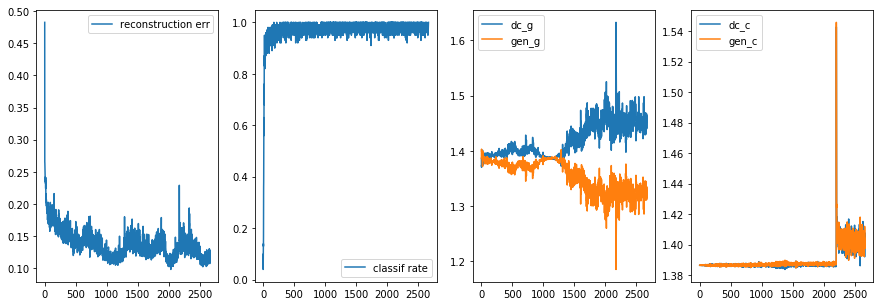

In [164]:
plt.figure(figsize = (15,5))
plt.subplot(1,4,1)
plt.plot(mem.decoder_eval)
plt.legend(('reconstruction err',))
plt.subplot(1,4,2)
plt.plot( mem.classif_eval)
plt.legend(('classif rate',))
plt.subplot(1,4,3)
plt.plot( mem.dc_g_eval)
plt.plot( mem.gen_g_eval)
plt.legend(('dc_g','gen_g'))
plt.subplot(1,4,4)
plt.plot( mem.dc_c_eval)
plt.plot( mem.gen_c_eval)
plt.legend(('dc_c','gen_c'))

In [165]:
x_test, y_test = mnist.test.next_batch(params.batch_size) #.images, mnist.test.labels #
print(accuracy.eval(feed_dict={x_input: x_test, y_label: y_test}))

0.97


print(accuracy.eval(feed_dict={x_input:subset_x[np.arange(params.batch_size)], y:subset_y[np.arange(params.batch_size)]}))

indices[:params.batch_size]

In [166]:
liste_z = e_latent_variable.eval(feed_dict={x_input: x_test})

In [167]:
liste_c = e_label_logit.eval(feed_dict={x_input: x_test})

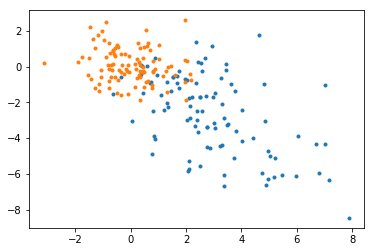

In [168]:
plt.plot(liste_z[:,0], liste_z[:,1], '.')
plt.plot(z_real_dist[:,0], z_real_dist[:,1], '.')

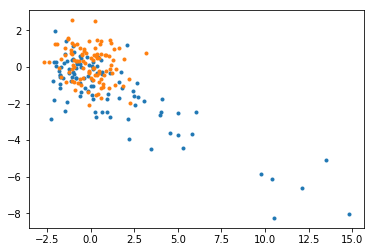

In [74]:
plt.plot(liste_z[:,0], liste_z[:,1], '.')
plt.plot(z_real_dist[:,0], z_real_dist[:,1], '.')

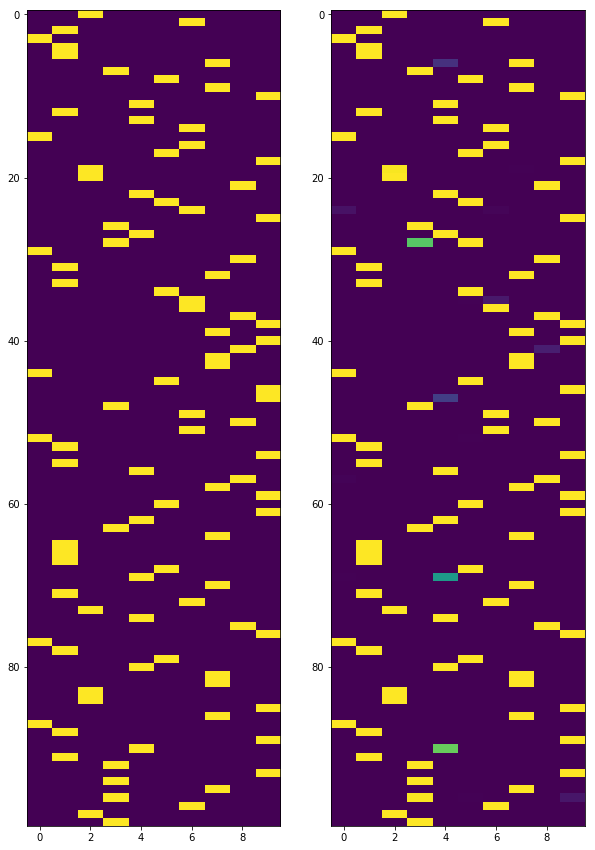

In [169]:
plt.figure(figsize =(10, 15))
plt.subplot(1,2,1)
plt.imshow(y_test, aspect = 'auto')
plt.subplot(1,2,2)
plt.imshow(1/(1+np.exp(-liste_c)), aspect = 'auto')

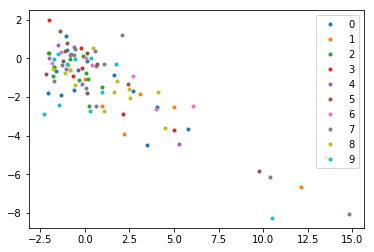

In [76]:
#liste_z = e_latent_variable.eval(feed_dict={x_input: batch_x})
z_cat = {}
for i in range(10):
    z_cat[i] = []
for i in range(len(liste_z)):
    index = np.where(batch_y[i] == 1)[0][0]
    z_cat[index] += [liste_z[i]]
for i in range(10):
    z_aff = np.transpose(z_cat[i])
    plt.plot(z_aff[0,:], z_aff[1,:], '.')
plt.legend((0,1,2,3,4,5,6,7,8,9))

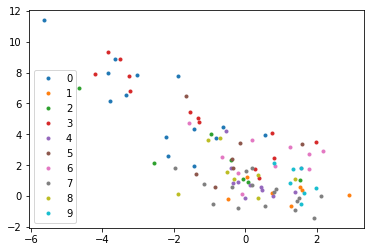

In [41]:
#liste_z = e_latent_variable.eval(feed_dict={x_input: x_test})
z_cat = {}
for i in range(10):
    z_cat[i] = []
for i in range(len(liste_z)):
    index = np.where(y_test[i] == 1)[0][0]
    z_cat[index] += [liste_z[i]]
for i in range(10):
    z_aff = np.transpose(z_cat[i])
    plt.plot(z_aff[0,:], z_aff[1,:], '.')
plt.legend((0,1,2,3,4,5,6,7,8,9))

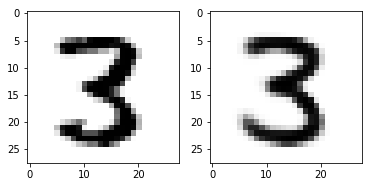

In [195]:
x_out = tf.nn.sigmoid(d_output).eval(feed_dict={x_input: x_test})
i = 7
plt.subplot(1,2,1)
plt.imshow(x_test[i].reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_out[i].reshape((28, 28)), cmap = 'gray_r')


In [43]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

3
[ 2.42072535  0.26213232  0.0659518  -0.87849343 -2.97480464  4.64506388
 -3.43511868  4.8777647  -6.08433819 -0.97082341 -2.37946248  2.2129643
 -1.37074077  2.53781343 -8.23129654]


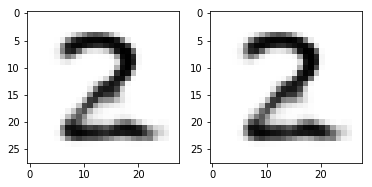

In [198]:
i = 7
cat_test = 2
cat = np.where(liste_c[i] == np.max(liste_c[i]))[0][0]
print(cat)
style = liste_z[i]
print(style)

decoder_feed = np.zeros(params.n_labels + params.z_dim)
# label
decoder_feed[cat_test] = 1
#np.concat(np.random.randn((params.z_dim)).reshape((1, params.z_dim))
# style
decoder_feed[params.n_labels:params.n_labels + params.z_dim] = style
decoder_feed = decoder_feed.reshape((1, params.n_labels + params.z_dim))

x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : decoder_feed})
plt.subplot(1,2,1)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')
plt.subplot(1,2,2)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')
#plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')


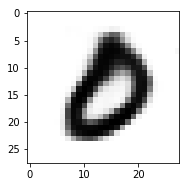

In [139]:
i = 0
decoder_feed = np.zeros(params.n_labels + params.z_dim)
# label
cat = sigmoid(liste_c[i])
decoder_feed[:params.n_labels] = cat
style = liste_z[i]
decoder_feed[params.n_labels:] = style
decoder_feed = decoder_feed.reshape((1, params.n_labels + params.z_dim))

x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : decoder_feed})
plt.subplot(1,2,1)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')

In [ ]:
# Random sample

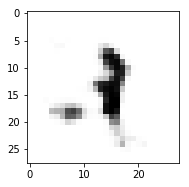

In [185]:
cat_test = 3
decoder_feed = np.zeros(params.n_labels + params.z_dim)
decoder_feed[cat_test] = 1
style = np.random.randn(params.z_dim)
decoder_feed[params.n_labels:] = style
decoder_feed = decoder_feed.reshape((1, params.n_labels + params.z_dim))

x_image = tf.nn.sigmoid(decoder_image).eval(feed_dict={decoder_input : decoder_feed})
plt.subplot(1,2,1)
plt.imshow(x_image.reshape((28, 28)), cmap = 'gray_r')